In [1]:
import main
import detection
import preprocessing as pp
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import math

# Load Images

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


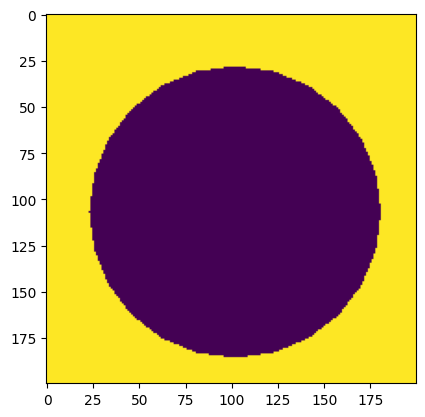

In [2]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


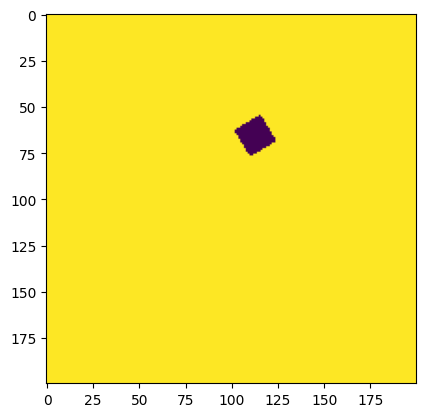

In [3]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = detection.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

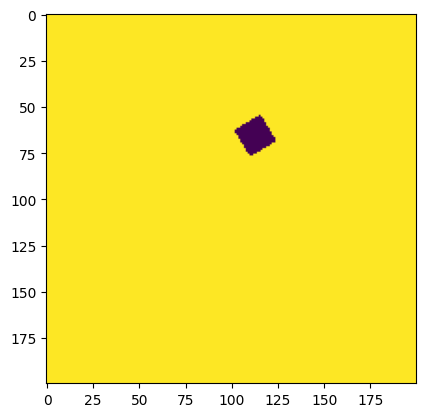

In [4]:
out = detection.draw_lines(img, lines)
main.plt.imshow(out)

# Test Edge Detection on Shapes

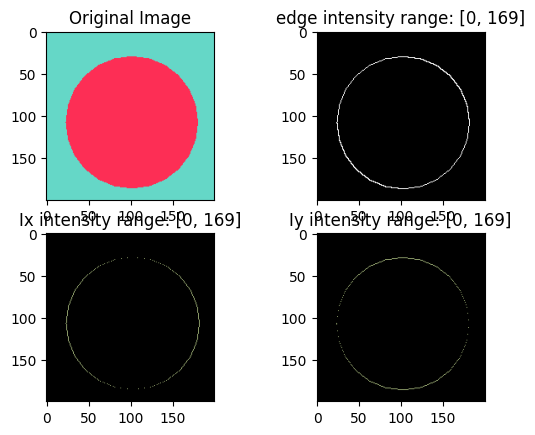

In [5]:
edges, Ix, Iy = pp.gradient(img_BGR, derv_len=1, use_sobel=False)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

# Test Edge Detection on Physical Parts

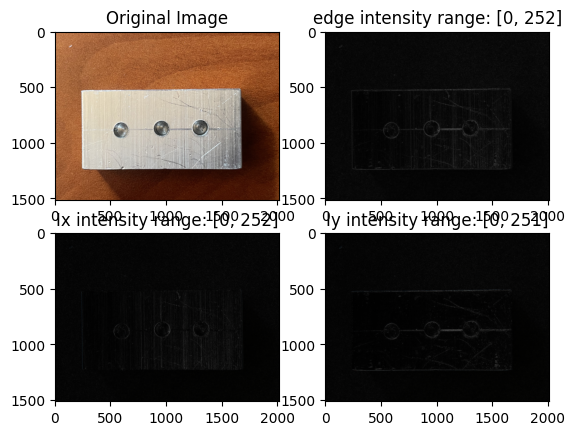

In [6]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")



img_part1 = pp.crop(main.load_img(img_path, greyscale=False))


edges, Ix, Iy = pp.gradient(img_part1, derv_len=1, use_sobel=False)



show_edge_results(img_part1, edges, Ix, Iy)

# Test edge detection with denoising

Main Idea:
1. Take simple gradient of original image to get *fine edges*, which will have noisy details

2. Blur original image and take gradient of blurred image to get *rough edges*, which will inflate obvious edges and filter out noisy details

3. Use the *rough edges* as a mask to extract wanted details from *fine edges* to get *masked fine edges*, which should contain only details near wanted edges

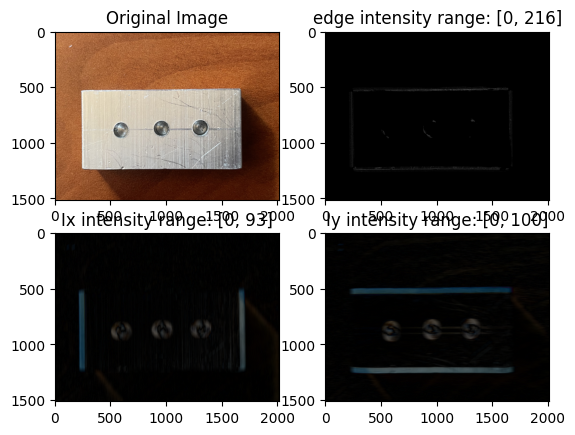

In [7]:
edges_masked, Ix, Iy = pp.getEdgesMasked(img_part1)

show_edge_results(img_part1, edges_masked, Ix, Iy)


# Run Hough Transform

TODO: Canny may not be necessary with our own edge detector

### A1: original -> Canny -> edges

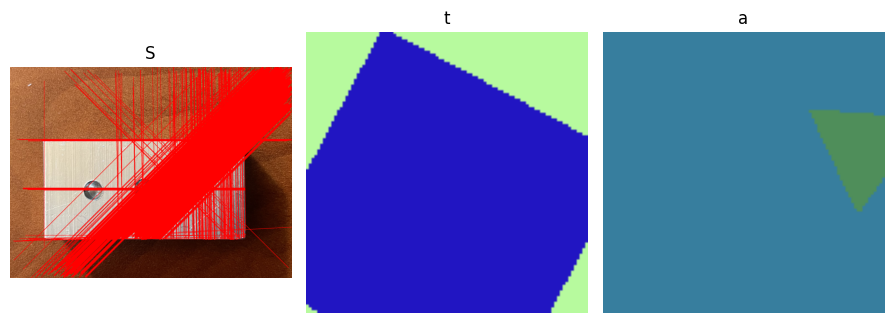

In [8]:

detection.subsample_technique(detection.DETECTION.LINE, "Standard A1 Hough Transform", lambda img: detection.applyHoughTransform(pp.crop(img)))

### A2: original -> Blur -> grad -> Threshold -> Canny -> edges

### A3: 
original -> grad ------------------> mask -> edges  
original -> blur -> grad -> thrs ->

In [9]:
# houghOutput = applyHoughTransform(edges_masked)
# showImage(houghOutput)

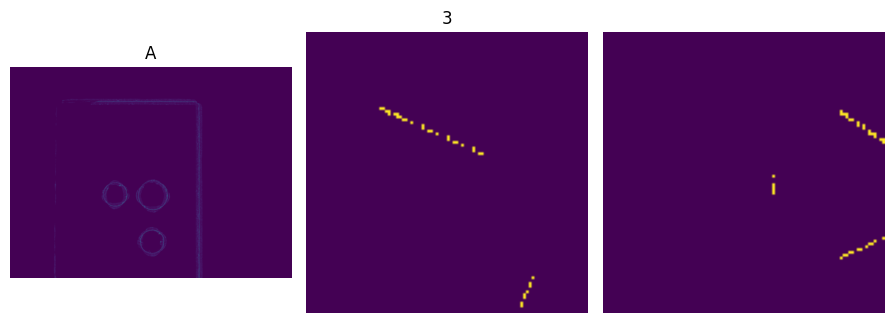

found 0 lines
found 0 lines


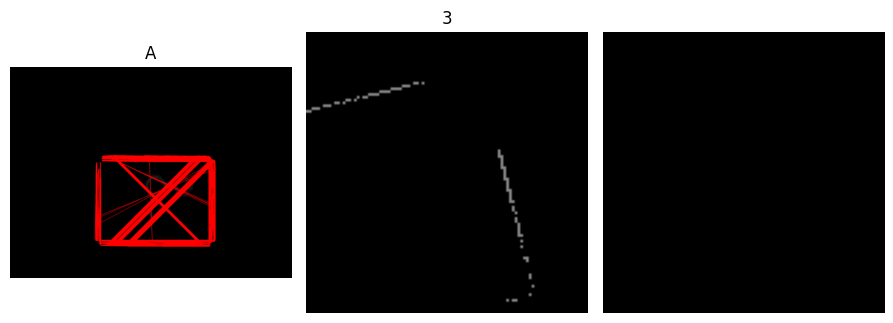

In [10]:
# APPROACH 3: first: org + FT + FLP -> LPF edges; then: LPF edge + Canny + HT
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: pp.getEdgesMasked(pp.crop(img))[0])
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0]))


### A4:
original -> grad ------------------> mask -> Canny -> edges  
original -> blur -> grad -> thrs ->


found 0 lines
found 0 lines


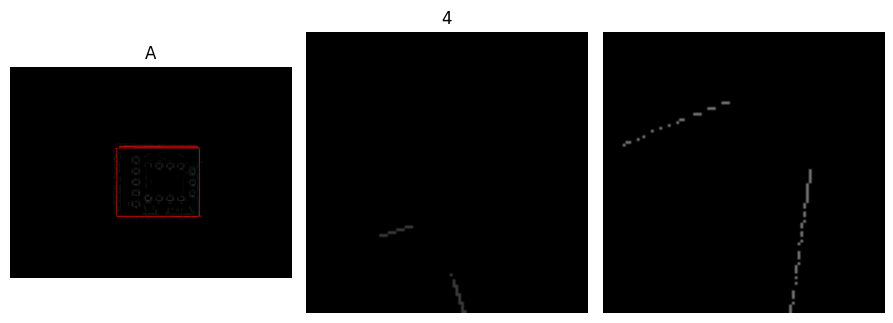

In [11]:
detection.subsample_technique(detection.DETECTION.LINE, "A4 Hough Transform", lambda img: detection.find_lines(pp.getEdgesMasked(pp.crop(img))[0], canny=True))

### General Insights in using HoughLinesP:
* Set maxLineGap to a large number to pick up long & continuous single lines
* Increase threshold to filter out short noisy lines
* Try not to set minLineLength too high, or actual features that are a bit short might be falsely ignored

### A5: original -> grad -> Canny -> edges

Total lines found: 1512


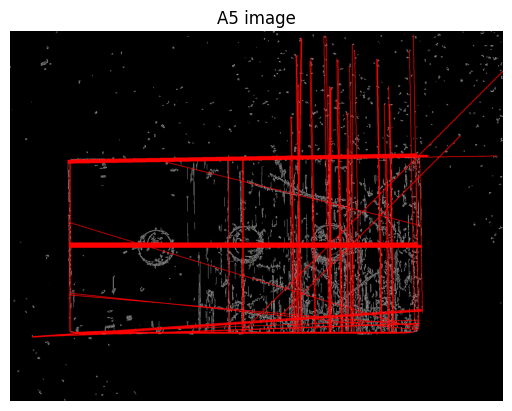

In [12]:
grad, _, _ = pp.gradient(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

found_lines_A5 = detection.find_lines(edges)
#print total lines found
print('Total lines found:', len(found_lines_A5) if found_lines_A5 is not None else 0)
detection.display_single_image(found_lines_A5, "A5 image")

Blur difference mean: 16.746648981476632
Blur difference mean: 1.806652244456463
Blur difference mean: 0.0202
Blur difference mean: 0.38549275919518133


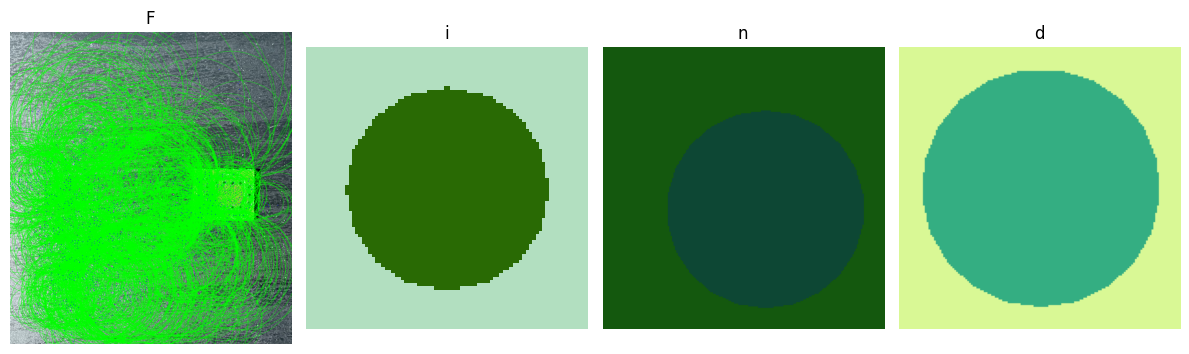

In [13]:


detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circles", lambda img: detection.find_circles(pp.crop_largest_structure(img)[0], blur=True, thresh=60))


found 848 circles
found 1 circles
found 1 circles
found 1 circles


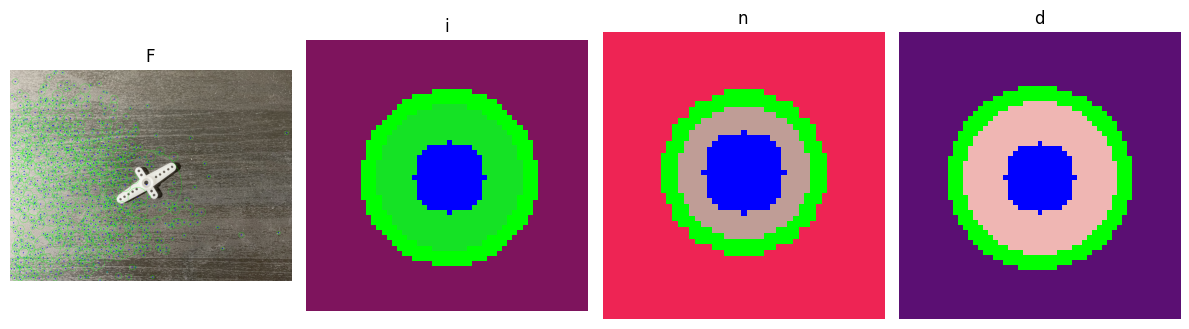

In [14]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours", lambda img: detection.find_circles_contours(pp.crop_largest_structure(img)[0], filter=180))


found 135 circles
found 1 circles
found 1 circles
found 1 circles


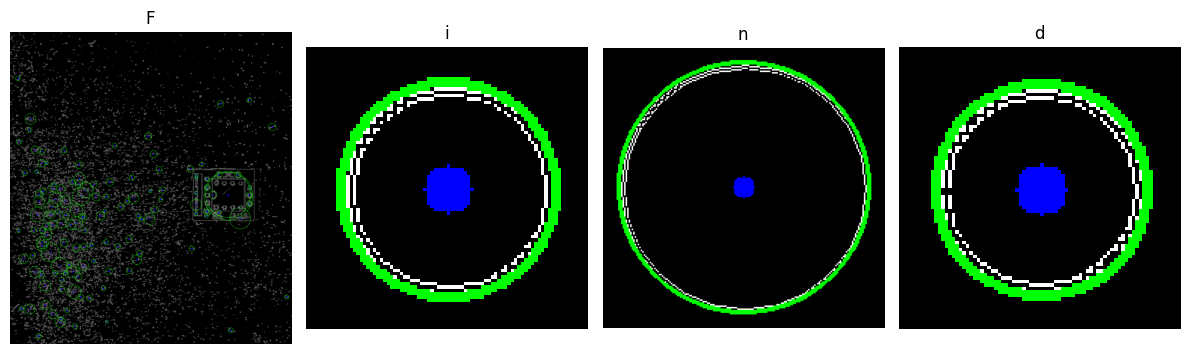

In [15]:
# grad, _, _ = pp.gradient(img_part1)
# # showImage(grad)
# edges = cv2.Canny(grad, 50, 150)
# # showImage(edges)

# found_circles_CT = find_circles_contours(edges, filter=60)
# showImage(found_circles_CT)

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle Contours + Canny", lambda img: detection.find_circles_contours(cv2.Canny(pp.gradient(pp.crop_largest_structure(img)[0])[0], 50, 150), filter=400))


# Ransac Circle Detection

Not enough edge points


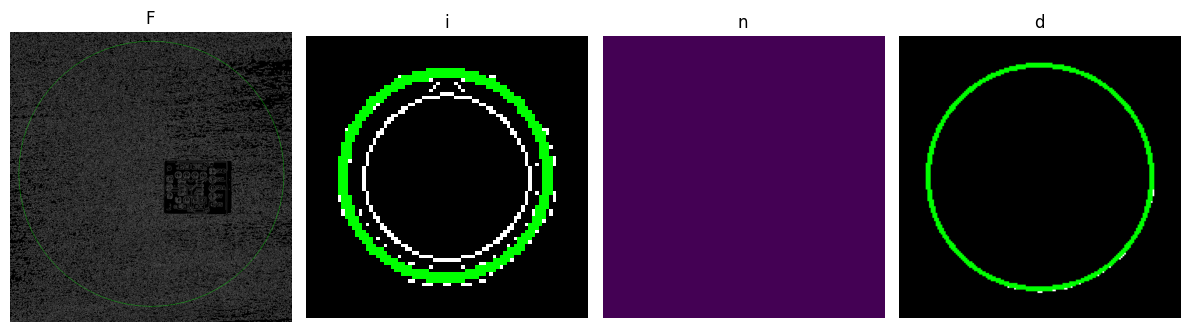

In [16]:

detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circle RANSAC", lambda img: detection.find_circle_ransac(pp.crop_largest_structure(img)[0]))


## Feature Matching Visualization
This section derives edge points using preprocessing (`get_edges` if available), matches detected lines to edges, and overlays results using `features.visualize_matches`.

using get_edges
using getEdgesMasked
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
edges: < (1512, 2016) >
raw found_lines count: 43
[match_points_to_lines] detected_lines: 43, min_length: 50.0
  line ref=(1137.0,515.0,1255.0,513.0) len=118.0 matched=475
  line ref=(1158.0,1232.0,1325.0,1232.0) len=167.0 matched=840
  line ref=(825.0,521.0,887.0,520.0) len=62.0 matched=250
  line ref=(1402.0,511.0,1480.0,510.0) len=78.0 matched=313
  line ref=(1085.0,877.0,1245.0,877.0) len=160.0 matched=0
  line ref=(1591.0,511.0,1644.0,510.0) len=53.0 matched=214
  line ref=(969.0,523.0,1038.0,521.0) len=69.0 matched=278
  line ref=(669.0,1233.0,725.0,1233.0) len=56.0 matched=285
  line ref=(715.0,871.0,815.0,871.0) len=100.0 matched=0
  line ref=(939.0,517.0,1078.0,517.0) len=139.0 matched=696
  line ref=(527.0,521.0,618.0,521.0) len=91.0 matched=426
  line ref=(1133.0,875.0,1222.0,875.0) len=89.0 matched=0
  line ref=(1338.0,

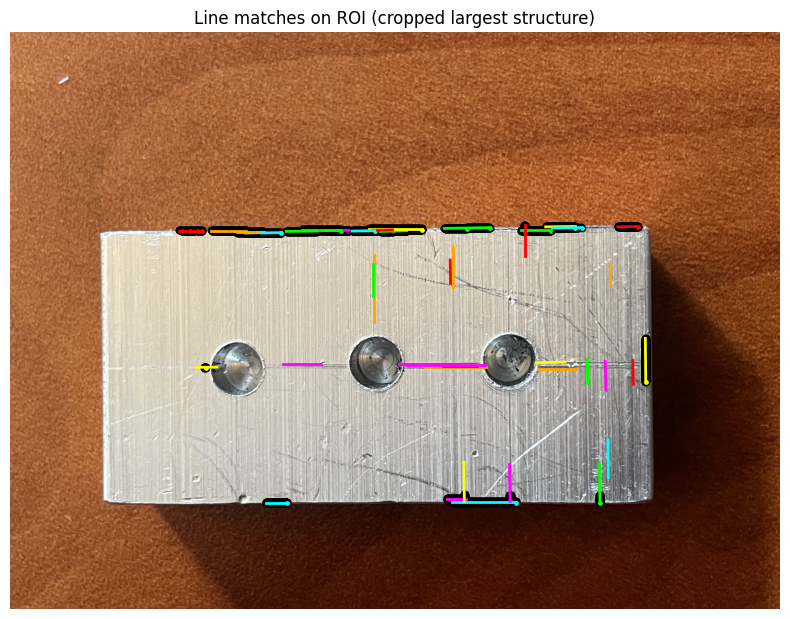

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Line matches on ROI (cropped largest structure)'}>)

In [18]:
from features import edge_points_from_image, match_points_to_lines, visualize_matches
import numpy as np
import cv2

# Focus ROI to reduce clutter and false positives
# roi = pp.crop_largest_structure(img_part1)[0]
roi = img_part1

# Extract edge points from the ROI (same frame used for detection/matching)
edge_points = edge_points_from_image(roi)

# Detect lines with stricter parameters to reduce spurious segments
found_lines = detection.detect_line(
    roi,
    canny_thres1=120, canny_thres2=240,
    rho=1, theta=np.pi/180,
    hough_thres=300,           # higher accumulator threshold
    min_line_len=50,           # require longer segments
    max_line_gap=5             # avoid merging distant short fragments
)
print('raw found_lines count:', len(found_lines) if found_lines is not None else 0)

# Match points to lines with tuned thresholds for gradient+Canny edges.
line_features = match_points_to_lines(found_lines or [], edge_points, max_perp_dist=2.0, min_length=50.0)
print('Matched features (lines):', len(line_features))
for i, f in enumerate(line_features):
    print(f'  Line {i}: ref={f.ref} matched_pts={len(f.pts)}')

# Visualize overlays on ROI
visualize_matches(roi, line_features, title='Line matches on ROI (cropped largest structure)')